In [1]:
import os
import json
import pandas as pd
import numpy as np

In [2]:
no_kg_outputs = 'outputs/no_kg_results.jsonl'
text_kg_outputs = 'outputs/text_kg_results.jsonl'
text_kg_1_outputs = 'outputs/text_kg_1_results.jsonl'
text_kg_2_outputs = 'outputs/text_kg_2_results.jsonl'

In [3]:
all_results = []

In [4]:
with open(no_kg_outputs, 'r') as f:
	no_kg_results = [json.loads(line) for line in f.readlines()]
with open(text_kg_outputs, 'r') as f:
	text_kg_results = [json.loads(line) for line in f.readlines()]
with open(text_kg_1_outputs, 'r') as f:
	text_kg_1_results = [json.loads(line) for line in f.readlines()]
with open(text_kg_2_outputs, 'r') as f:
	text_kg_2_results = [json.loads(line) for line in f.readlines()]
with open('/home/jovyan/manish-thesis/thesis-implementations/quest_generation/llama2/data/val.jsonl', 'r') as f:
	val_set = [json.loads(line) for line in f.readlines()]

In [5]:
for no_kg_result, text_kg_result, text_kg_1_result, text_kg_2_result, val in zip(no_kg_results, text_kg_results, text_kg_1_results, text_kg_2_results, val_set):
    result = {
    	'desc' : val['quest']['description'],
		'game' : val['game'],
		'no_kg_input': no_kg_result['input'],
		'text_kg_input': text_kg_result['input'],
		'no_kg': no_kg_result['output_gen'][:-10][11:],
		'text_kg': text_kg_result['output_gen'][:-10][11:],
		'text_1_kg': text_kg_1_result['output_gen'][:-10][11:],
		'text_2_kg': text_kg_2_result['output_gen'][:-10][11:],
  		'actual': no_kg_result['output_actual'][:-10][11:],
	}
    all_results.append(result)

In [6]:
results_df = pd.DataFrame(all_results)

In [7]:
results_df.head()

,desc,game,no_kg_input,text_kg_input,no_kg,text_kg,text_1_kg,text_2_kg,actual
0,Thank you for rescuing me. I had recovered the...,TL2,### Plots:\nthe player freed Elder Josimon fro...,### Background:\nElder Josimon is a character....,Title: The passkey ember\nObjective: Bring eld...,Title: The elder's request\nObjective: Bring e...,Title: The watchweald portal\nObjective: Find ...,Title: The ember keys\nObjective: Find the emb...,Title: Up in smoke\nObjective: Put the slavers...
1,Name's Valdr. I hunt out of Falkreath.\nWe tra...,TESS,"### Plots:\nValdr, Ari and Niels tracked a bea...",### Background:\nValdr is a character. Valdr i...,Title: The spriggans\nObjective: Find the spri...,Title: Moss mother cavern\nObjective: Kill the...,Title: The quest related to the above informat...,Title: The hunt\nObjective: Help valdr track d...,Title: Moss mother cavern\nObjective: Help val...
2,My daughter is gone! I left my home in your ca...,BG2,### Plots:\nGarren Windspear left his home in ...,### Background:\nGarren Windspear is a charact...,Title: The windspear daughter\nObjective: Help...,Title: The windspear family\nObjective: Rescue...,Title: Garren windspear's daughter\nObjective:...,Title: The lost daughter\nObjective: Find garr...,Title: Rescue garren's child from firkraag\nOb...
3,You're really going to the Blue Palace? That p...,TESS,### Plots:\nthe player told Taarie that the pl...,### Background:\nTaarie is a character. Taarie...,Title: A gift for the queen\nObjective: Bring ...,Title: The blue palace\nObjective: Deliver a l...,Title: The blue palace\nObjective: Give jarl e...,Title: The radiant raiment\nObjective: Find th...,Title: Fit for a jarl\nObjective: Promote the ...
4,Why are you people doing this? Is it informati...,TESS,### Plots:\nthe player is torturing their pris...,### Background:\nSolitude is a location. Solit...,Title: The prisoner's inheritance\nObjective: ...,Title: A secret to die for\nObjective: Find th...,Title: The heir to the throne\nObjective: Find...,Title: The hidden inheritance\nObjective: Find...,Title: The inheritance\nObjective: Find the hi...


In [8]:
out_file = os.path.join('outputs', f'all_results.jsonl')
with open(out_file, 'w') as outfile:
	for result in all_results:
		json.dump(result, outfile)
		outfile.write('\n')

In [8]:
import bert_score
from bert_score import BERTScorer
bert_score.__version__

import logging
import transformers
transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)

In [9]:
scorer = BERTScorer(model_type='microsoft/deberta-xlarge-mnli', lang="en")

In [10]:
no_kg_out = [x['no_kg'] for x in all_results]
tree_kg_out = [x['text_kg'] for x in all_results]
tree_1_kg_out = [x['text_1_kg'] for x in all_results]
tree_2_kg_out = [x['text_2_kg'] for x in all_results]
actual_out = [x['actual'] for x in all_results]

In [11]:
_, _, n_t_F1 = scorer.score(no_kg_out, tree_kg_out)
_, _, n_a_F1 = scorer.score(no_kg_out, actual_out)
_, _, t_a_F1 = scorer.score(tree_kg_out, actual_out)

_, _, n_t1_F1 = scorer.score(no_kg_out, tree_1_kg_out)
_, _, n_t2_F1 = scorer.score(no_kg_out, tree_2_kg_out)

_, _, t_t1_F1 = scorer.score(tree_kg_out, tree_1_kg_out)
_, _, t_t2_F1 = scorer.score(tree_kg_out, tree_2_kg_out)
_, _, t1_t2_F1 = scorer.score(tree_1_kg_out, tree_2_kg_out)

_, _, t1_a_F1 = scorer.score(tree_1_kg_out, actual_out)
_, _, t2_a_F1 = scorer.score(tree_2_kg_out, actual_out)

In [12]:
f1_scores_df = pd.DataFrame({'noXtree': n_t_F1,
                             'noXactual': n_a_F1,
                             'noXtree1': n_t1_F1,
                             'noXtree2': n_t2_F1,
                             'treeXactual': t_a_F1,
                             'treeXtree1': t_t1_F1,
                             'treeXtree2': t_t2_F1,
                             'tree1Xactual': t1_a_F1,
                             'tree2Xactual': t2_a_F1,
                             'tree1Xtree2': t1_t2_F1
                            })

In [15]:
f1_scores_df.mean().round(2)

noXtree         0.75
noXactual       0.71
noXtree1        0.73
noXtree2        0.69
treeXactual     0.74
treeXtree1      0.77
treeXtree2      0.70
tree1Xactual    0.73
tree2Xactual    0.68
tree1Xtree2     0.70
dtype: float32

In [14]:
f1_scores_df.std().round(2)

noXtree         0.06
noXactual       0.05
noXtree1        0.06
noXtree2        0.09
treeXactual     0.07
treeXtree1      0.07
treeXtree2      0.09
tree1Xactual    0.06
tree2Xactual    0.09
tree1Xtree2     0.09
dtype: float32

In [16]:
f1_scores_df.to_csv('all_bertscores.csv', index=False)

In [15]:
all_scores = pd.read_csv('all_bertscores.csv')

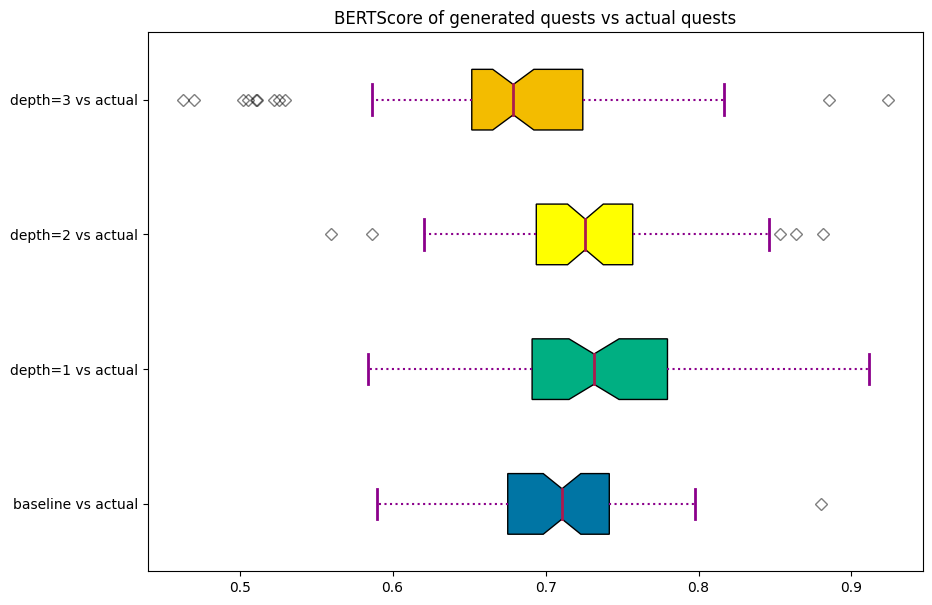

In [28]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
# Creating dataset
np.random.seed(10)
data_1 = all_scores['noXactual']
data_2 = all_scores['treeXactual']
data_3 = all_scores['tree1Xactual']
data_4 = all_scores['tree2Xactual']
data = [data_1, data_2, data_3, data_4]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#0075a4', '#00af82', 
          '#FFFF00', '#f3bc00']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='#ac1a4e',
               linewidth = 2)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_yticklabels(['baseline vs actual', 'depth=1 vs actual', 'depth=2 vs actual', 'depth=3 vs actual'])
 
# Adding title 
plt.title("BERTScore of generated quests vs actual quests")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()
